In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
image_path = './example.jpg'
def show(img,title=" "):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (5,5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()
def get(imagePath):
    return cv2.imread(imagePath, cv2.IMREAD_UNCHANGED)

### Preprocessing Example.

In [3]:
test = get(image_path)

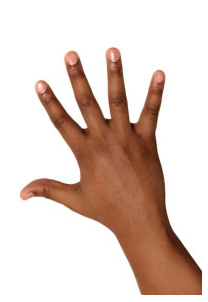

In [4]:
show(test)

### Segement Image by color.

In [5]:
def skinmask(img):
    hsvim = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 48, 80], dtype = "uint8")
    upper = np.array([20, 255, 255], dtype = "uint8")
    skinRegionHSV = cv2.inRange(hsvim, lower, upper)
    blurred = cv2.blur(skinRegionHSV, (2,2))
    ret, thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY)
    return thresh

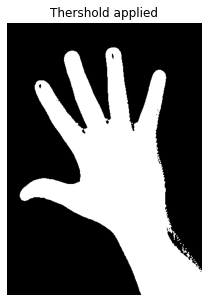

In [14]:
process1 = skinmask(test)
show(process1,"Thershold applied")

### Closing

In [ ]:
def closing(img):
    dilation = cv2.dilate(img,(15,15),iterations = 10)
    closing = cv2.erode(dilation,(15,15),iterations = 10)
    return closing

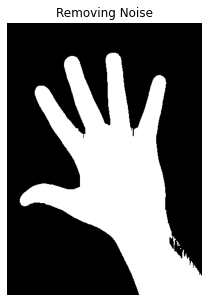

In [15]:
process2 = closing(process1)
show(process2,"Removing Noise")

### Finding Contours and Hull

In [9]:
def getcnthull(mask_img):
    contours, hierarchy = cv2.findContours(mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = max(contours, key=lambda x: cv2.contourArea(x))
    hull = cv2.convexHull(contours)
    return contours, hull

Contour is the line that circumvent an object, while the hull contains it.

### Finding Convexity Defects

In [10]:
def getdefects(contours):
    hull = cv2.convexHull(contours, returnPoints=False)
    defects = cv2.convexityDefects(contours, hull)
    return defects

A defect is a deivation from the hull in the contour, this can be applied to get the points between fingers.

<font color=red> Limitation:</font> <font size=2>Doesn't work very well when the fingers are closed together.</font>

### Estimating Fingers

In [11]:
def estimateFingers(contours):
    defects = getdefects(contours)
    if defects is not None:
        cnt = 0
        for i in range(defects.shape[0]):  # calculate the angle
            s, e, f, d = defects[i][0]
            start = tuple(contours[s][0])
            end = tuple(contours[e][0])
            far = tuple(contours[f][0])
            a = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
            b = np.sqrt((far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2)
            c = np.sqrt((end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2)
            #cosine theorem
            angle = np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))  
                
            if angle <= np.pi / 2:  # angle less than 90 degree, treat as fingers
                cnt += 1
                cv2.circle(img, far, 4, [0, 0, 255], -1)
        if cnt > 0:
            cnt = cnt+1
        return cnt

# Real Time

In [13]:
cap = cv2.VideoCapture(0) # '0' for webcam
while cap.isOpened():
    _, img = cap.read()
    try:
        mask_img = skinmask(img)
        closing_img = closing(mask_img)
        contours, hull = getcnthull(closing_img)
        cv2.drawContours(img, [contours], -1, (255,255,0), 2)
        cv2.drawContours(img, [hull], -1, (0, 255, 255), 2)
        fingers = str(estimateFingers(contours))
        cv2.putText(img, fingers, (0, 50), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 0, 0) , 2, cv2.LINE_AA)
        
        merged = cv2.hconcat([img, cv2.cvtColor(closing_img,cv2.COLOR_GRAY2RGB)])
        
        cv2.imshow("Project CS483", merged)

    except:
        pass
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

## Feature Improvments

#### Feed the algorithem with hands only (detect hands) and apply only to bounding box.
### Train a model on a thresholded database to predict gestures.